Language prediction from character-wise surnames.


In [29]:
%matplotlib inline

!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


--2020-04-05 19:54:50--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.45.116, 13.226.45.35, 13.226.45.86, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.45.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  15.6MB/s    in 0.2s    

2020-04-05 19:54:50 (15.6 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
['data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Japanese.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Italian.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Vietnamese.

Build a list of names per language.

In [0]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [31]:
print(category_lines['Chinese'][:5])

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']


Convert names to Pytorch tensors. We will do it character-by-character, so each letter is one-hot encoded.

In [32]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('B'))

print(lineToTensor('Bai').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([3, 1, 57])


Quick helper function to get names/languages.

In [33]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Tedesco
category = Greek / line = Bilias
category = Arabic / line = Zogby
category = Japanese / line = Shintaro
category = English / line = Lenihan
category = French / line = Brisbois
category = Polish / line = Gorski
category = Italian / line = Ambrogi
category = Czech / line = Pesek
category = Korean / line = Byon


Another helper function to convert output logits to language.

In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

OK, now let's define our network and train the model. We will use a recurrent neural network (RNN) with a hidden state vector of size 128. It will pass each character sequentially (remember each character is one-hot encoded) and then finally perform a softmax to get the 18 classes.

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

OK, great. Let's train this network. Each loop of training will read each letter in, keep the hidden state for the next letter, and compare the final output with the target label using Cross Entropy Loss. This will be used to backpropagate through the weights.

In [0]:
lr = 0.005
criterion = nn.NLLLoss()

def train(category_tensor,line_tensor):
  hidden=rnn.initHidden()
  rnn.zero_grad()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i],hidden)
  
  loss = criterion(output,category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(-lr,p.grad.data)
  
  return output, loss.item()
  
def test(line_tensor):
  hidden = rnn.initHidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

OK! Now we can run a script to monitor the training process. Observe how the loss decreases over time. 

In [37]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []


for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'Y' if guess == category else 'N (%s)' % category
        print('%d %d%% %.4f %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% 2.8812 Albuquerque / German N (Portuguese)
10000 10% 2.3976 Odriscoll / Italian N (English)
15000 15% 1.8143 Salib / Arabic Y
20000 20% 3.0821 Ui / Korean N (Japanese)
25000 25% 3.8161 Raske / Polish N (Dutch)
30000 30% 1.1736 Yeo / Chinese N (Korean)
35000 35% 2.7148 Knopf / Arabic N (German)
40000 40% 2.6530 Kubin / Russian N (Czech)
45000 45% 2.1725 Millar / Scottish N (English)
50000 50% 0.4774 Soares / Portuguese Y
55000 55% 1.9418 Blanco / Italian N (Spanish)
60000 60% 0.6971 O'Neal / Irish Y
65000 65% 1.6441 Arreola / Portuguese N (Spanish)
70000 70% 2.7261 Seger / German N (Czech)
75000 75% 1.1403 Phi / Vietnamese Y
80000 80% 4.0694 Salazar / Polish N (Spanish)
85000 85% 0.3784 Zhu / Chinese Y
90000 90% 0.4804 Hew / Chinese Y
95000 95% 0.2778 Yang / Korean Y
100000 100% 0.8105 Remishevsky / Russian Y


Great! Seems like things are improving. We can now compute a confusion matrix to see how well we have done.

In [0]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = test(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

Let's visualize the confusion matrix!

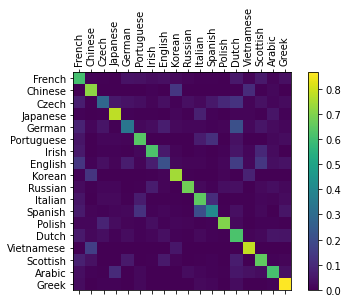

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()